In [1]:
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline

E:\Anaconda\Lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 导入人脸关键点检测模型
mp_face_mesh = mp.solutions.face_mesh
model = mp_face_mesh.FaceMesh(
    static_image_mode=False,# 是否是静态图片
    refine_landmarks=True,
    max_num_faces=5,# 最大人脸数量
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5
)
# 导入可视化函数和可视化样式
mp_drawing = mp.solutions.drawing_utils # 画关键点
# 关键点可视化样式
landmark_drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=2,color=(66, 77, 229))
# 轮廓可视化样式
contour_drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1,color=(223, 155,6))

In [3]:
from seetaface.api import *
# 人脸识别比对，返回两张图片的相似度
def face_recognition(recognize_frame, character):
    # 启用多个功能人脸检测、人脸识别和关键点标记
    init_mask = FACE_DETECT|FACERECOGNITION|LANDMARKER5
    seetaface = SeetaFace(init_mask)

     # 提取识别的人脸特征
    detect_result1 = seetaface.Detect(recognize_frame) 
    face1 = detect_result1.data[0].pos #脸部位置信息face1
    points1 = seetaface.mark5(recognize_frame, face1) # 标记face1区域的5个关键点
    feature1 = seetaface.Extract(recognize_frame, points1) # 关键点的脸部特征提取
    
    # 人脸数据比对
    detect_result2 = seetaface.Detect(character)
    face2 = detect_result2.data[0].pos
    points2 = seetaface.mark5(character,face2)
    feature2 = seetaface.Extract(character,points2)
    
    #计算两个特征值的形似度
    similar = seetaface.CalculateSimilarity(feature1,feature2)
    
    return similar

In [4]:
from seetaface.api import *
# 人脸追踪
def face_recognition_track(image):
    init_mask = FACE_DETECT
    seetaFace = SeetaFace(init_mask)
    
    # 设置最小检测人脸大小
    seetaFace.SetProperty(DetectProperty.PROPERTY_MIN_FACE_SIZE,80)
    # 设置最小检测人脸阈值0.9，大于0.9得分的人脸才返回
    seetaFace.SetProperty(DetectProperty.PROPERTY_THRESHOLD,0.9)
    
    # 检测图像中的人脸位置
    detect_result = seetaFace.Detect(image)
    
    # 返回一个SeetaFaceInfoArray类型的数据
    return detect_result

In [5]:
# 眼间距离（去不同像素下的尺寸对比值）
def relative_unit_distance(img,results, retract):
     # 获取图像的宽高
    h, w = img.shape[0], img.shape[1]
    
    # 相对不动点距离
    stable_point1 = results.multi_face_landmarks[retract].landmark[133]
    stable_point2 = results.multi_face_landmarks[retract].landmark[362]
    stable_numpy_point1 = np.array([stable_point1.x * w, stable_point1.y * h, stable_point1.z])
    stable_numpy_point2 = np.array([stable_point2.x * w, stable_point2.y * h, stable_point2.z])
    
    # 引入容差值进行比较，防止相对不动点的距离过小
    tolerance = 1e-6
    if np.allclose(stable_numpy_point1, stable_numpy_point2, atol=tolerance):
        return 1.0
    else:
        return np.linalg.norm(stable_numpy_point1 - stable_numpy_point2)

In [29]:
# 计算两个关键点之间的距离
import numpy as np

def distance_landmark(img,results, retract, point_id1, point_id2):
    # 获取图像的宽高
    h, w = img.shape[0], img.shape[1]
    
    # 获取指定面部的两个关键点的坐标
    landmark1 = results.multi_face_landmarks[retract].landmark[point_id1]
    landmark2 = results.multi_face_landmarks[retract].landmark[point_id2]

    # 将 landmark 的 x, y, z 转化为 numpy 数组
    point1 = np.array([landmark1.x * w, landmark1.y * h, landmark1.z])
    point2 = np.array([landmark2.x * w, landmark2.y * h, landmark2.z])
    
    # 计算欧式距离
    dist = np.linalg.norm(point1 - point2)
    
    return dist

In [7]:
# 计算点到平面的距离
import numpy as np

# 计算点到平面的距离
def point_to_plane_distance(plane_normal, plane_point, point):
    dist = np.dot(plane_normal, (point - plane_point)) / np.linalg.norm(plane_normal)
    return np.abs(dist)

# 计算plane_point_id1, plane_point_id2, plane_point_id3构成的平面与点集point_id_list的距离
def distance_to_plane(img, results, retract, plane_point_id1, plane_point_id2, plane_point_id3, point_id_list):
    # 获取图像的宽高
    h, w = img.shape[0], img.shape[1]

    # 获取三个定义平面的点的坐标
    landmark1 = results.multi_face_landmarks[retract].landmark[plane_point_id1]
    landmark2 = results.multi_face_landmarks[retract].landmark[plane_point_id2]
    landmark3 = results.multi_face_landmarks[retract].landmark[plane_point_id3]

    # 将 landmark 的 x, y, z 坐标转化为 numpy 数组并调整比例
    point1 = np.array([landmark1.x * w, landmark1.y * h, landmark1.z])
    point2 = np.array([landmark2.x * w, landmark2.y * h, landmark2.z])
    point3 = np.array([landmark3.x * w, landmark3.y * h, landmark3.z])

    # 计算平面的法向量
    v1 = point2 - point1
    v2 = point3 - point1
    
    # 使用np.array_equal来比较两个数组是否完全相等
    if np.array_equal(v1, v2):
        return None
    else:
        plane_normal = np.cross(v1, v2)

    # 计算每个点到平面的距离
    distances = []
    for point_id in point_id_list:
        landmark = results.multi_face_landmarks[retract].landmark[point_id]
        point = np.array([landmark.x * w, landmark.y * h, landmark.z])
        dist = point_to_plane_distance(plane_normal, point1, point)
        distances.append(dist)

    return np.array(distances)


In [8]:
# 计算点集到直线的距离
import numpy as np

def point_to_line_distance(line_point1, line_point2, point):
    # 计算点到直线的距离
    line_vec = line_point2 - line_point1
    point_vec = point - line_point1
    # 计算投影点到线段的垂直距离
    distance = np.linalg.norm(np.cross(line_vec, point_vec)) / np.linalg.norm(line_vec)
    return distance

def distance_to_line(img, results, retract, start_point_id, end_point_id, point_id_list):
    # 获取图像的宽高
    h, w = img.shape[0], img.shape[1]

    # 获取直线的两个点的坐标
    landmark1 = results.multi_face_landmarks[retract].landmark[start_point_id]
    landmark2 = results.multi_face_landmarks[retract].landmark[end_point_id]

    # 将 landmark 的 x, y, z 坐标转化为 numpy 数组并调整比例
    line_point1 = np.array([landmark1.x * w, landmark1.y * h, landmark1.z])
    line_point2 = np.array([landmark2.x * w, landmark2.y * h, landmark2.z])

    # 计算每个点到直线的距离
    distances = []
    for point_id in point_id_list:
        landmark = results.multi_face_landmarks[retract].landmark[point_id]
        point = np.array([landmark.x * w, landmark.y * h, landmark.z])
        dist = point_to_line_distance(line_point1, line_point2, point)
        distances.append(dist)

    return np.array(distances)


In [9]:
# 绘制红色重点标记点
def show_point(img, results, retract, point_id):
    # 获取图像的宽高
    h, w = img.shape[0], img.shape[1]
    
    # 获取指定关键点的坐标
    x = int(results.multi_face_landmarks[retract].landmark[point_id].x * w)
    y = int(results.multi_face_landmarks[retract].landmark[point_id].y * h)
    img = cv2.circle(img, (x,y), 5, (0,0,255), -1)
    
    return img

def show_points(img, results, retract, point_id_list):
    for point_id in point_id_list:
        img = show_point(img, results, retract, point_id)
    return img

E:\Anaconda\Lib\site-packages\google\protobuf\symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


9.67205159905334
[0.00000000e+00 2.37072030e-02 5.26403857e-02 7.64697191e-02
 8.08421412e-02 6.02764655e-02 2.54991973e-02 1.35034756e-17]
[ 0.          3.97940257  9.38523013 14.25017566 15.5457212  12.06320706
  5.13974687  0.        ]


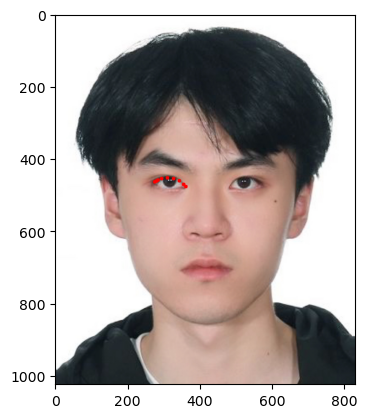

In [10]:
# 导入基础库
import cv2
import mediapipe as mp
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline



# 定义可视化图像
def look_img(img):
    # opencv读入的图像格式为BGR，而matplotlib的imshow函数需要RGB格式，因此需要转换下格式
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
mp_face_mesh = mp.solutions.face_mesh

# 测试
model = mp_face_mesh.FaceMesh(
    static_image_mode=True, # 是否为静态图片，如果是，则每次输入的图片必须相同尺寸
    refine_landmarks=True, # 使用 Attention Mesh 模型，对眼睛、瞳孔周围的关键点精细定位
    min_detection_confidence=0.5, # 置信度阈值，越接近 1 越准确
    min_tracking_confidence=0.5 # 追踪成功率阈值，越接近 1 越准确
)
    
# 导入可视化函数和可视化样式
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

img = cv2.imread('../users_database/baojiachen.jpg')

# 获取图像的宽高
h, w = img.shape[0], img.shape[1]

# BGR to RGB
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 将RGB图像输入模型，并得到检测结果
results = model.process(img_RGB)

a = distance_landmark(img,results, 0, 246, 7)

print(a)

show_point(img, results, 0, 33)
show_point(img, results,0,133)

# 测试点集到平面的距离
lists = [246, 161, 160, 159, 158, 157,173,133]
show_points(img, results, 0, lists)
distances1 = distance_to_plane(img, results, 0, 246, 133, 197, lists)
print(distances1)
distances2 = distance_to_line(img, results, 0, 246,133, lists)
print(distances2)


look_img(img)

In [11]:
# 判断是否闭眼


In [11]:
# 处理单帧的函数
def process_frame(img):
    # 记录该祯开始处理的时间
    t0 = time.time()
    scaler = 1 # 文字大小
    
    # 获取图像的宽高
    h, w = img.shape[0], img.shape[1]
    
    # BGR to RGB
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 将RGB图像输入模型，并得到检测结果
    results = model.process(img_RGB)
    
    # 如果有检测到人脸，则开始绘制人脸曲面和重点区域轮廓线
    if results.multi_face_landmarks: # 如果有检测到人脸
        for face_landmarks in results.multi_face_landmarks: # 遍历每一张人脸
            # 绘制人脸轮廓线
            mp_drawing.draw_landmarks(
                image=img, # 输入图像
                landmark_list=face_landmarks, # 关键点
                connections=mp_face_mesh.FACEMESH_CONTOURS, # 连接点
                landmark_drawing_spec=landmark_drawing_spec,# 关键点样式,默认为None
                connection_drawing_spec=contour_drawing_spec # 连接点样式
           )
            
            # 遍历关键点，添加序号
            for idx,coord in enumerate(face_landmarks.landmark):# 遍历关键点
                cx = int(coord.x * w)
                cy = int(coord.y * h)
                # 图片、添加的文字、左上角的坐标、字体、字体大小、颜色、字体粗细
                img = cv2.putText(img, 'Face Detected', (25 * scaler, 50 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 1)
                img = cv2.putText(img, str(idx), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.3 * scaler, (0, 255, 0), 1)
    else:
        # 如果没有检测到人脸，则提示
        # No face detected的提示只能是英文，否则会显示?????
        img = cv2.putText(img, 'No face detected!', (25 * scaler, 50 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 2 * scaler)
        
    # 记录该帧处理完毕的时间
    t1 = time.time()
    
    # 计算每秒处理图像帧数FPS
    FPS = 1 / (t1 - t0)
    
    img = cv2.putText(img, 'FPS: '+ str(int(FPS)), (25 * scaler, 100 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255))
    
    return img

In [13]:
# 处理单帧的函数（结合面部的识别）
def process_frame2(img):
    # 记录该祯开始处理的时间
    t0 = time.time()
    scaler = 1 # 文字大小
    
    # 匹配人脸数据
    img1=cv2.imread("../users_database/baojiachen.jpg")
    
    # 获取图像的宽高
    h, w = img.shape[0], img.shape[1]
    
    # BGR to RGB
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 将RGB图像输入模型，并得到检测结果
    results = model.process(img_RGB)
    
    # 如果有检测到人脸，则开始绘制人脸曲面和重点区域轮廓线
    if results.multi_face_landmarks: # 如果有检测到人脸
        for face_landmarks in results.multi_face_landmarks: # 遍历每一张人脸
            # 绘制人脸轮廓线
            mp_drawing.draw_landmarks(
                image=img, # 输入图像
                landmark_list=face_landmarks, # 关键点
                connections=mp_face_mesh.FACEMESH_CONTOURS, # 连接点
                landmark_drawing_spec=landmark_drawing_spec,# 关键点样式,默认为None
                connection_drawing_spec=contour_drawing_spec # 连接点样式
           )
            
            # 人脸识别
            similar = face_recognition(img_RGB,img1)
            
            # 遍历关键点，添加序号
            for idx,coord in enumerate(face_landmarks.landmark):# 遍历关键点
                cx = int(coord.x * w)
                cy = int(coord.y * h)
                # 图片、添加的文字、左上角的坐标、字体、字体大小、颜色、字体粗细
                img = cv2.putText(img, 'Face Detected', (25 * scaler, 50 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 1)
                img = cv2.putText(img, str(idx), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.3 * scaler, (0, 255, 0), 1)
    else:
        # 如果没有检测到人脸，则提示
        # No face detected的提示只能是英文，否则会显示?????
        img = cv2.putText(img, 'No face detected!', (25 * scaler, 50 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 2 * scaler)
        
    # 记录该帧处理完毕的时间
    t1 = time.time()
    
    # 计算每秒处理图像帧数FPS
    FPS = 1 / (t1 - t0)
    
    img = cv2.putText(img, 'FPS: '+ str(int(FPS)), (25 * scaler, 100 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255))
    
    return img

In [14]:
# 测试面部识别模块
img1=cv2.imread("../asserts/seeta1.jpg")
img2=cv2.imread("../asserts/seeta2.jpg")
face_recognition(img1,img2)

0.722508430480957

In [15]:
# 测试模块——用于测试人脸识别模块
detect_result = face_recognition_track(img1)
for i in range(detect_result.size):
    face = detect_result.data[i].pos
    cv2.rectangle(img1, (face.x, face.y), (face.x + face.width, face.y + face.height), (255, 0, 0),2)

cv2.imshow("s",img1)
cv2.waitKey(0) # 等待键盘输入

-1

In [31]:
# 测试模块——用于测试识别结果是否正确输出
# 调用摄像头获取每帧
# 导入opencv读取视频的库
import cv2
import time
from seetaface.api import *

try:
    # 获取摄像头，传入0表示获取系统默认摄像头。如果是MacOS，则需要传入1
    cap = cv2.VideoCapture(0)

    # 打开capture
    cap.open(0)

    # 限制人脸识别的频率
    frame_counts = 0
    
    # 匹配人脸数据
    img=cv2.imread("../users_database/baojiachen.jpg")

    # 无线循环，直至断开连接
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Ignoring empty")
            break
        # 人脸识别
        if frame_counts % 120 == 0:
            similar = face_recognition(frame,img)
            print(similar) # 输出相似度
            frame_counts = 0
            
        #增加帧计数    
        frame_counts += 1
        
        # 处理帧
        frame = process_frame(frame)
        
        # 显示处理后的帧
        cv2.imshow('frame', frame)
    
        # 等待键盘输入，27为esc键，ord用于将字符转为ASCII码
        if cv2.waitKey(1) in [27, ord('q')]:
            break
except Exception as e:
    print("Error!")
finally: 
    # 释放摄像头
    cap.release()
    
    # 关闭所有窗口
    cv2.destroyAllWindows()

0.7782438397407532


In [30]:
# 仅作面部分割，不做人脸识别
# 调用摄像头获取每帧
# 导入opencv读取视频的库
import cv2
import time
from seetaface.api import *

# 获取摄像头，传入0表示获取系统默认摄像头。如果是MacOS，则需要传入1
cap = cv2.VideoCapture(0)

# 打开capture
cap.open(0)

# 无线循环，直至断开连接
while cap.isOpened():
    # 读取摄像头数据
    ret, frame = cap.read()
    if not ret:
        print("Ignoring empty")
        break
        
    # 处理帧
    frame = process_frame(frame)
    
    # 显示处理后的帧
    cv2.imshow('frame', frame)
    
    # 等待键盘输入，27为esc键，ord用于将字符转为ASCII码
    if cv2.waitKey(1) in [27, ord('q')]:
        break
        
# 释放摄像头
cap.release()

# 关闭所有窗口
cv2.destroyAllWindows()